# Lagged Data
Implementation of a models with lagged data.

In [75]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn import linear_model, svm
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from ipynb.fs.full.get_data import getTFData, lagData

In [63]:
train, test = getTFData(sets = [1], maxrul = 125)

drops = ['dt', 'set1', 'set2', 'set3', 's1', 's5', 's6', 's10', 's16', 's18', 's19']
train = train.drop(columns = drops)
test = test.drop(columns = drops)

First, investigate how much lag is possible without loosing data due to dropna.

In [52]:
maxlag = test[['id','rul']].groupby('id').size().min() - 1
print("Maximal Lag without NA is %d" %maxlag)

Maximal Lag without NA is 30


### Basic Linear Regression with Lagged Data

In [64]:
train_b = train.copy()
test_b = test.copy()

In [65]:
lagsize = 15
dropna = True

train_b = lagData(train_b, lagsize, dropna)

temp = test_b.groupby('id')
temp = pd.concat([temp.tail(lagsize + 1)])
test_b = lagData(temp, lagsize, dropna)

In [17]:
rul = 2
rulfrac = 1

r, c = train.shape
Xtrain = train_b.iloc[:, 1:(c - rul)].values
Ytrain = train_b.iloc[:, (c - rul)].values

Xtest = test_b.iloc[:, 1:(c- rul)].values
Ytest = test_b.iloc[:, (c - rul)].values

In [19]:
# simple linear regression model
laglm_base = linear_model.LinearRegression()
laglm_base.fit(Xtrain, Ytrain)

LinearRegression()

In [20]:
Ypred_train = laglm_base.predict(Xtrain)
Ypred = laglm_base.predict(Xtest)

In [21]:
print("Training:")
print("Sqrt mse: %.2f" % np.sqrt(mean_squared_error(Ytrain, Ypred_train)))
print("Coefficient of determination: %.2f" % r2_score(Ytrain, Ypred_train))

print("Testing:")
print("Sqrt mse: %.2f" % np.sqrt(mean_squared_error(Ytest, Ypred)))
print("Coefficient of determination: %.2f" % r2_score(Ytest, Ypred))

Training:
Sqrt mse: 39.45
Coefficient of determination: 0.63
Testing:
Sqrt mse: 28.47
Coefficient of determination: 0.53


## Timeseries Analysis
Colinearity issue.

In [70]:
trbs = train_b.drop(columns = ['id', 'rulfrac'])

In [73]:
s3 = [s for s in trbs.columns if 's3' in s]

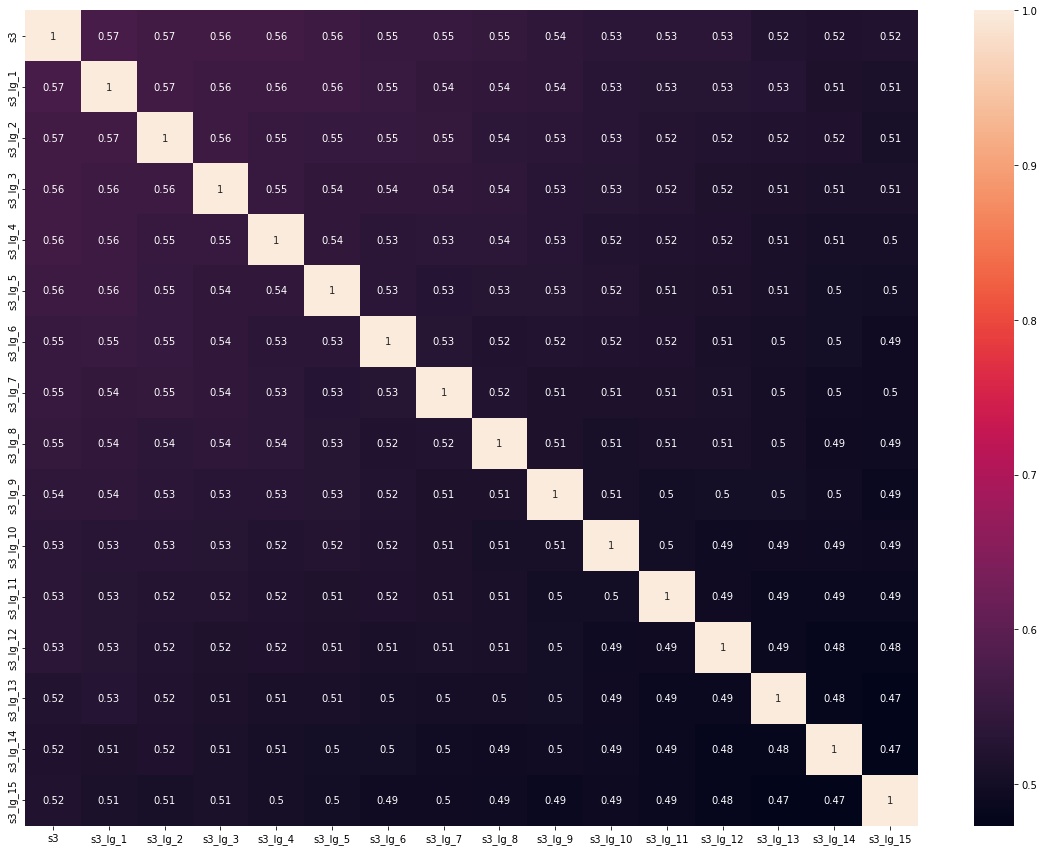

In [74]:
corrmat = trbs[s3].corr()
plt.subplots(figsize = (20 , 15))
sns.heatmap(corrmat, annot = True)
plt.show()

## Regression with Scaled and Lagged Data

In [53]:
# lag data
train = lagData(train, lagsize = maxlag, dropna = True)

temp = test.groupby('id')
temp = pd.concat([temp.tail(maxlag + 1)])

test = lagData(temp, lagsize = maxlag, dropna = True)

In [55]:
rul = 2
rulfrac = 1

r, c = train.shape
Xtrain = train.iloc[:, 1:(c - rul)].values
Ytrain = train.iloc[:, (c - rul)].values

Xtest = test.iloc[:, 1:(c- rul)].values
Ytest = test.iloc[:, (c - rul)].values

In [56]:
scaler = StandardScaler()
scaler.fit(Xtrain)
Xtrain_sc = scaler.transform(Xtrain)
Xtest_sc = scaler.transform(Xtest)

In [58]:
lmsc = linear_model.LinearRegression()
lmsc.fit(Xtrain_sc, Ytrain)

Ypred_train = lmsc.predict(Xtrain_sc)
Ypred = lmsc.predict(Xtest_sc)

print("Training:")
print("Sqrt mse: %.2f" % np.sqrt(mean_squared_error(Ytrain, Ypred_train)))
print("Coefficient of determination: %.2f" % r2_score(Ytrain, Ypred_train))

print("Testing:")
print("Sqrt mse: %.2f" % np.sqrt(mean_squared_error(Ytest, Ypred)))
print("Coefficient of determination: %.2f" % r2_score(Ytest, Ypred))

Training:
Sqrt mse: 16.54
Coefficient of determination: 0.84
Testing:
Sqrt mse: 15.76
Coefficient of determination: 0.85


## SVR

In [ ]:
poly = PolynomialFeatures(2)
Xtrain_tf = poly.fit_transform(Xtrain_sc)
Xtest_tf = poly.fit_transform(Xtest_sc)

svr_tf = svm.SVR(kernel = 'linear')
svr_tf.fit(Xtrain_tf, Ytrain)

select_features = SelectFromModel(svr_tf, threshold = 'mean', prefit = True)

svr_sf = svm.SVR(kernel='linear')
svr_sf.fit(Xtrain_tf[:, select_features.get_support()], Ytrain)

Ypred_sft = svr_sf.predict(Xtrain_tf[:, select_features.get_support()])
print("Training:")
print("Sqrt mse: %.2f" % np.sqrt(mean_squared_error(Ytrain, Ypred_sft)))
print("Coefficient of determination: %.2f" % r2_score(Ytrain, Ypred_sft))
Ypred_sf = svr_sf.predict(Xtest_tf[:, select_features.get_support()])
print("Testing:")
print("Sqrt mse: %.2f" % np.sqrt(mean_squared_error(Ytest, Ypred_sf)))
print("Coefficient of determination: %.2f" % r2_score(Ytest, Ypred_sf))